## Identify enriched motifs

In [2]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
# from sklearn.neighbors import NearestNeighbors
# from matplotlib.collections import LineCollection
# import pickle

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.pipeline import config
from chromograph.pipeline.utils import div0
from chromograph.peak_calling.utils import *
from chromograph.preprocessing.utils import *

import cytograph as cg
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class Motif_Aggregator:
    def __init__(self, *, f: Union[float, List[float]] = 0.5) -> None:
        '''
        Aggregate the motif scores, find markers and call the auto-annotater
        '''
        self.f = f
        self.config = config.load_config() # Generic config, just to get the paths

    def fit(self, ds: loompy.LoomConnection, out_file: str, agg_spec: Dict[str, str] = None) -> None:
        '''
        Aggregate the Gene-Accessibility signal, find markers and call the auto-annotater
        
        Args:
            ds              LoomConnection. Dataset must contain ds.ra.Gene and ds.ca.Clusters
            outfile         Filename of aggregation file
            agg_spec        Dictionary containing numpy-groupies function to be applied to column attributes
        '''
        self.outdir = '/' + os.path.join(*out_file.split('/')[:-1], 'exported')

        if agg_spec is None:
            agg_spec = {
                "Age": "tally",
                "Clusters": "first",
                "Class": "mode",
                "Total": "mean",
                "Sex": "tally",
                "Tissue": "tally",
                "SampleID": "tally",
                "TissuePool": "first",
                "Outliers": "mean",
                "PCW": "mean"
            }
        cells = ds.col_attrs["Clusters"] >= 0
        labels = ds.col_attrs["Clusters"][cells]
        n_labels = len(set(labels))

        logging.info("Aggregating clusters")
        ds.aggregate(out_file, None, "Clusters", "mean", agg_spec)
        with loompy.connect(out_file) as dsout:

            if n_labels <= 1:
                return

            logging.info("Computing cluster gene enrichment scores")
            self.mask = Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt"))
            fe = FeatureSelectionByMultilevelEnrichment(mask=self.mask)
            markers = fe.fit(ds)
            dsout.layers["enrichment"] = fe.enrichment

            ## Save top N most enriched genes
            Most_enriched = [dsout.ra.Gene[dsout['enrichment'][:,i].argsort()[::-1][:self.config.params.N_most_enriched]].tolist() for i in range(dsout.shape[1])]
            dsout.ca.Most_enriched = [" ".join(enr) for enr in Most_enriched]
            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)
            
            # Reorder the genes, markers first, ordered by enrichment in clusters
            logging.info("Permuting rows")
            mask = np.zeros(ds.shape[0], dtype=bool)
            mask[markers] = True
            # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
            gene_order = np.zeros(ds.shape[0], dtype='int')
            gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
            gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
            gene_order = np.argsort(gene_order)
            ds.permute(gene_order, axis=0)
            dsout.permute(gene_order, axis=0)

['', 'MMP', 'MZ', 'smooth']


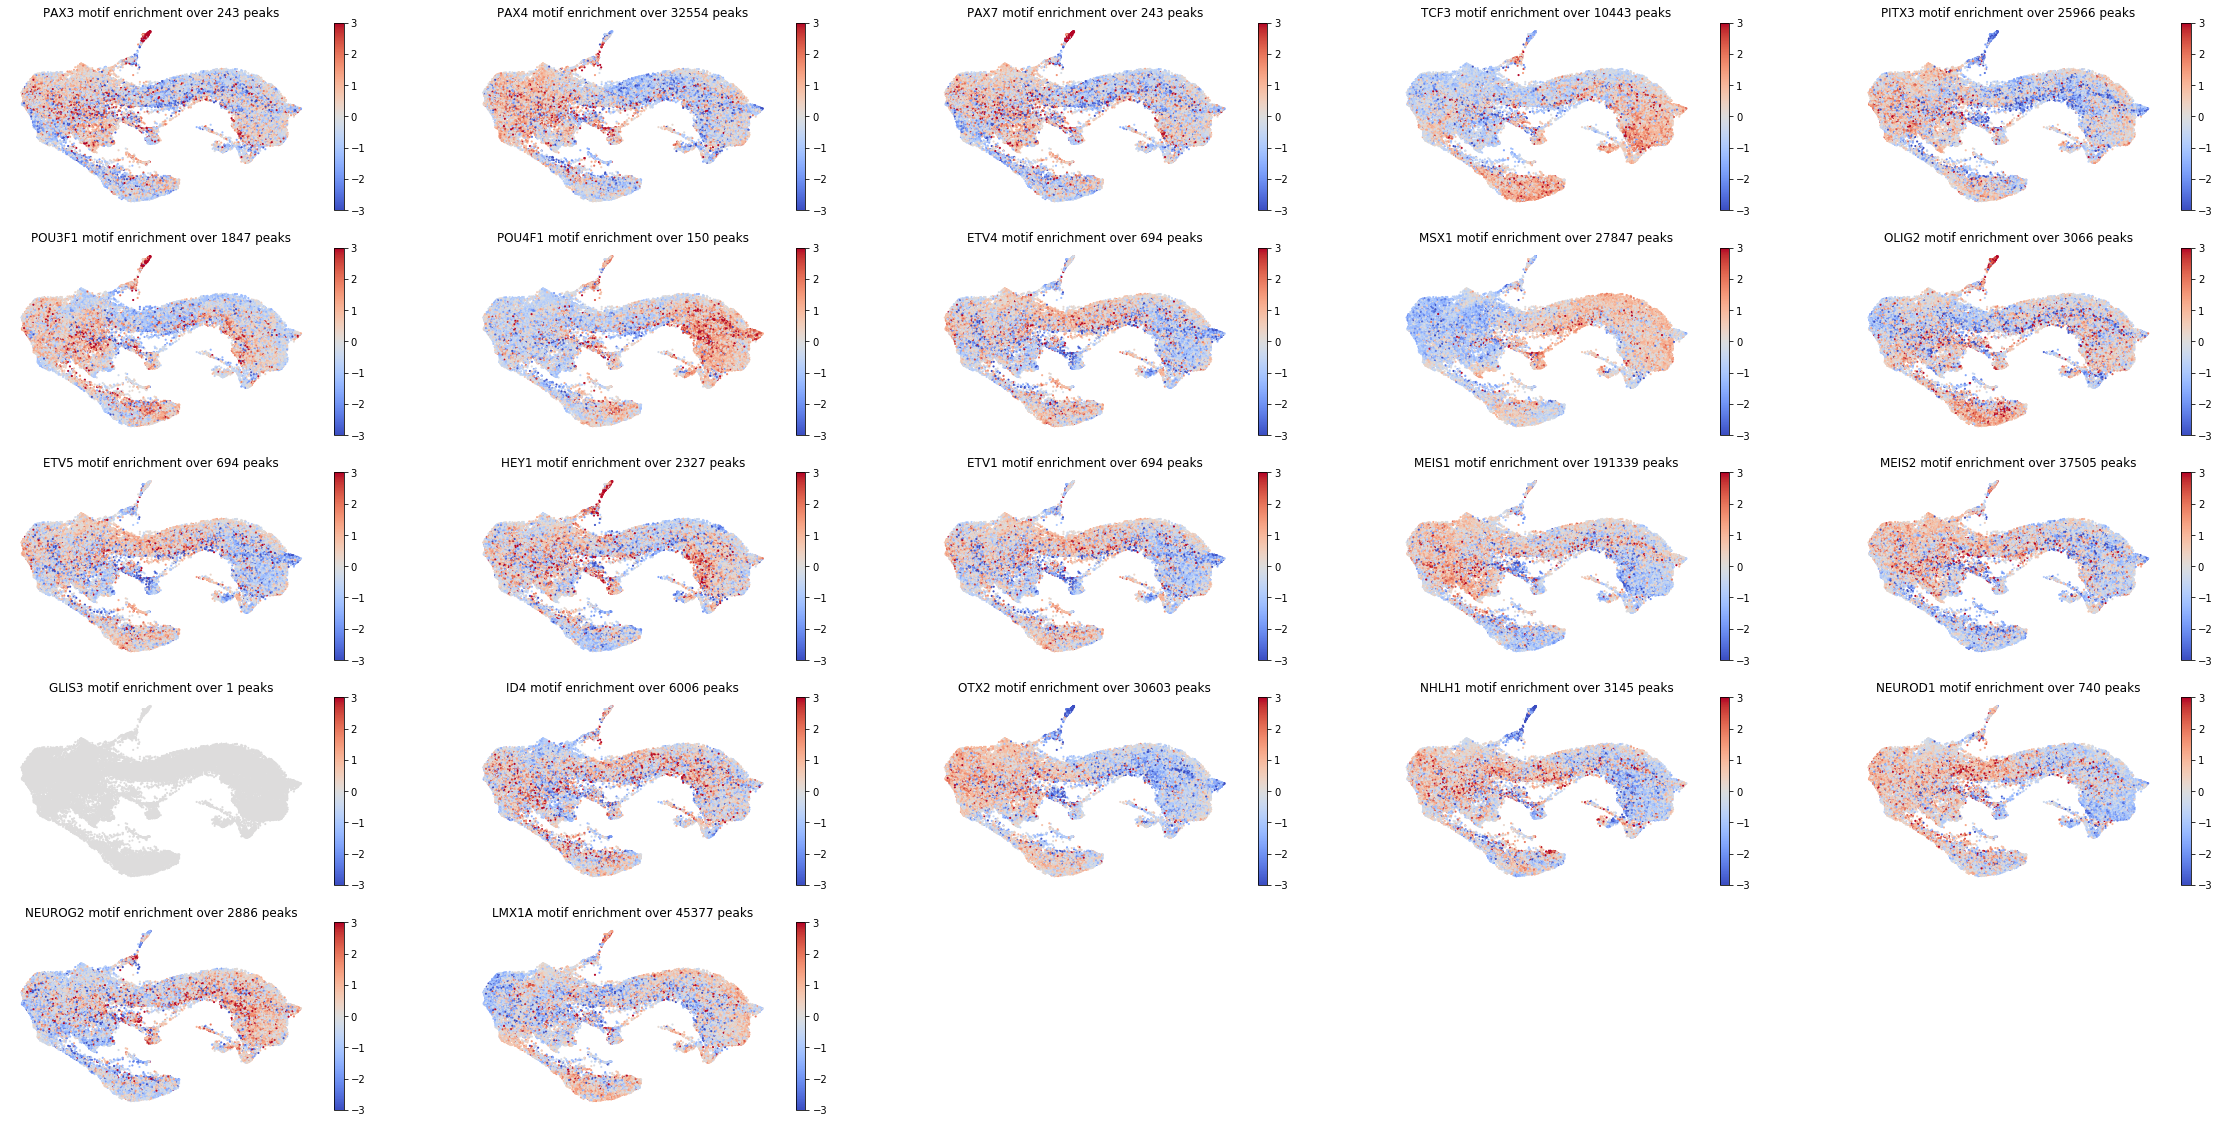

In [7]:
fdir = '/data/proj/scATAC/chromograph/build_20200611/Cerebellum/'
file = os.path.join(fdir, 'Cerebellum_motifs.loom')

markers = ['PAX3', 'PAX4', 'PAX7', 'TCF3', 'PITX3', 'POU3F1', 'POU4F1', 'ETV4', 'MSX1', 'OLIG2', 'ETV5', 'HEY1', 
           'ETV1', 'MEIS1', 'MEIS2', 'GLIS3', 'ID4', 'OTX2', 'NHLH1', 'NEUROD1', 'NEUROG2', 'LMX1A', 'MRC1', 'LUM', 'ATOH1', 'PTF1A']

with loompy.connect(file) as ds:
    print(ds.layers.keys())
    m = [marker for marker in markers if marker in ds.ra['Gene']]
    motif_plot(ds, '/home/camiel/misc/chromograph_tmp/motif_plots.png', m, 'UMAP')

In [6]:
markers = ['PTF1A', 'PRDM13', 'PAX2', 'PAX3', 'PAX4', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 'PITX3', 'POU3F1', 'POU4F1',
           'ETV4', 'LHX3', 'LHX4', 'MSX1', 'GABPB2', 'SAMD13', 'OLIG2', 'ETV5', 'IRX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'MEIS1', 'MEIS2',
           'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 'SALL2', 'OTX2', 'HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 
           'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2', 'NEUROD6', 'ZNF33A', 'PHTF1', 'LMX1A']

import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def motif_plot(ds: loompy.LoomConnection, out_file: str, markers: list, embedding: str = "TSNE", layer: str = 'MZ') -> None:
    '''
    Generates a multi-panel plot to inspect Gene Accessibility Scores.
    
    Args:
        ds                    Connection to the .loom file to use
        markers               List of markers by Genesymbol to plot
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (1500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(np.ceil(nM/5)*8, 20))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## motif score    
        v = ds[layer][ds.ra['Gene'] == m, :][0]
        
        im = ax.scatter(pos[:,0], pos[:,1], cmap='coolwarm', c=v, vmin = -3, vmax = 3, 
                        marker='.', lw=0, s=epsilon)
        
        fig.colorbar(im, ax=ax, orientation='vertical')
        ax.set_title(f'{m} motif enrichment over {ds.ra["Total_peaks"][ds.ra["Gene"]==m][0]} peaks')
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')
    


In [ ]:
  
import numpy as np
import loompy
import logging
from cytograph.plotting.heatmap import Heatmap


def Motifheatmap(ds: loompy.LoomConnection, dsagg: loompy.LoomConnection, out_file: str = "", layer: str = "pooled") -> None:
	if layer not in ds.layers:
		logging.warn(f"Cannot plot heatmap for layer {layer} because the layer doesn't exist")
		return
	n_clusters = ds.ca.Clusters.max() + 1
	hm = Heatmap(np.arange(10 * n_clusters), attrs={
		"Clusters": "categorical",
		"SampleName": "categorical",
		"SampleID": "categorical",
		"Tissue": "ticker",
		"Sex": "categorical",
		"Age": "categorical",
		"TotalUMI": "plasma:log",
		"CellCycle_G1": "viridis:log",
		"CellCycle_S": "viridis:log",
		"CellCycle_G2M": "viridis:log",
		"DoubletFinderScore": "viridis",
		"DoubletFinderFlag": "PiYG_r"
	}, layer=layer)
	hm.plot(ds, dsagg, out_file=out_file)

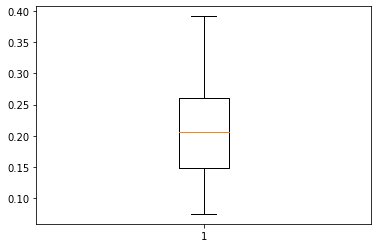

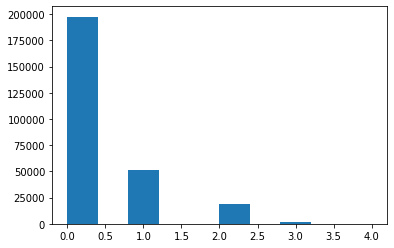

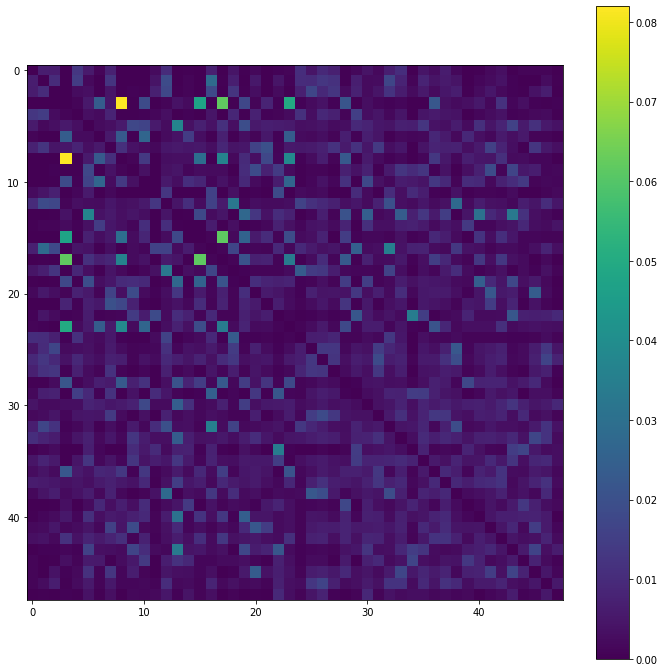

In [17]:
## Plot Betas
from scipy.spatial.distance import jaccard

f = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'

with loompy.connect(f, 'r') as ds:
    lim = 1 - (2000/ds.shape[0])
    peaks = np.zeros(ds.ra.HPF.shape)
    q = []
    for i in range(ds.ra.HPF.shape[1]):
        q.append(np.quantile(ds.ra.HPF[:,i], lim))
#         logging.info(f'Top 2000 peaks have Beta over: {q[i]}')
        peaks[:,i] = ds.ra.HPF[:,i] > q[i]
    plt.figure()
    plt.boxplot(q)
    plt.figure()
    plt.hist(np.sum(peaks, axis = 1))
    
    jac = np.zeros([ds.ra.HPF.shape[1], ds.ra.HPF.shape[1]])
    for i in range(ds.ra.HPF.shape[1]):
        for j in range(i+1, ds.ra.HPF.shape[1]):
            jac[i,j] = 1 - jaccard(peaks[:,i], peaks[:,j])
            jac[j,i] = jac[i,j]
            
    plt.figure(figsize=(12,12))
    plt.imshow(jac)
    plt.colorbar()

In [67]:
with loompy.connect(f, 'r') as ds:
    i = 0
    locs = np.vstack([ds.ra['Chr'][peaks[:,i]>0], ds.ra['Start', 'End'][peaks[:,i]>0,:].T, ds.ra['ID'][peaks[:,i]>0]]).T
    bed = BedTool(locs.tolist()).saveas()
    fpeaks = os.path.join(os.getcwd(), 'tmp', f'C{i}_peaks.bed')
    bed = bed.each(extend_fields, 6).each(add_strand, '+').saveas(fpeaks)
    print(bed.head())
    print(bed.count())
    
#     outdir = os.path.join(os.getcwd(), 'tmp')
#     cmd = f'findMotifsGenome.pl {fpeaks} hg38 {outdir} -size 200 -mask'
#     os.system(cmd)

chr1	4624953	4625737	chr1:4624952-4625737	.	+
 chr1	5143009	5143644	chr1:5143008-5143644	.	+
 chr1	5397957	5398719	chr1:5397956-5398719	.	+
 chr1	5613879	5614514	chr1:5613878-5614514	.	+
 chr1	5690387	5691059	chr1:5690386-5691059	.	+
 chr1	6653246	6654230	chr1:6653245-6654230	.	+
 chr1	7494910	7495446	chr1:7494909-7495446	.	+
 chr1	9916463	9917086	chr1:9916462-9917086	.	+
 chr1	11545752	11546883	chr1:11545751-11546883	.	+
 chr1	11585286	11586054	chr1:11585285-11586054	.	+
 None
2000


In [ ]:
findMotifsGenome.pl C0_peaks.bed hg38 tmp_out -bg C0_bg.bed -size 200 -mask -nomotif

In [4]:
## Motif alignment



'/var/lib/condor/execute/dir_14603'

In [95]:
from chromograph.preprocessing.utils import *
blacklist = get_blacklist('GRCh38')
blacklist = BedTool(blacklist)

with loompy.connect(f, 'r') as ds:
    i = 14
    locs = np.vstack([ds.ra['Chr'][peaks[:,i]>0], ds.ra['Start', 'End'][peaks[:,i]>0,:].T, ds.ra['ID'][peaks[:,i]>0]]).T
    bg = np.vstack([ds.ra['Chr'][peaks[:,i]==0], ds.ra['Start', 'End'][peaks[:,i]==0,:].T, ds.ra['ID'][peaks[:,i]==0]]).T
    
    bed = BedTool(locs.tolist()).saveas()
    fpeaks = os.path.join(os.getcwd(), 'tmp', f'C{i}_peaks.bed')
    bed = bed.each(extend_fields, 6).each(add_strand, '+').saveas(fpeaks)

    bg_bed = BedTool(bg.tolist()).saveas()
    fbg = os.path.join(os.getcwd(), 'tmp', f'C{i}_bg.bed')
    bg_bed = bg_bed.each(extend_fields, 6).each(add_strand, '+').saveas(fbg)

    print(bed.count())
    print(bg_bed.count())
    

18:28:49 INFO     Retrieved blacklist for GRCh38


2000
268213


In [98]:
with loompy.connect(f, 'r') as ds:
    print(ds.ra.keys())

['Annotation', 'Chr', 'Coverage', 'CpG%', 'Detailed Annotation', 'Distance to TSS', 'End', 'Entrez ID', 'Focus Ratio-Region Size', 'GC%', 'Gene Alias', 'Gene Description', 'Gene Name', 'Gene Type', 'HPF', 'HPF_beta', 'ID', 'NCells', 'Nearest Ensembl', 'Nearest PromoterID', 'Nearest Refseq', 'Nearest Unigene', 'Peak Score', 'Start', 'Strand', 'Valid']


In [85]:
## Annotate peaks
        homer = os.path.join(self.config.paths.HOMER, 'annotatePeaks.pl')
        genes = os.path.join(self.config.paths.ref, 'genes', 'genes.gtf')
        motifs = os.path.join(self.config.paths.ref, 'regions', 'motifs.pfm')
        f_annot = os.path.join(self.peakdir, 'annotated_peaks.txt')
        cmd = f'{homer} {f} hg38 -gtf {genes} -m {motifs} > {f_annot}'  ## Command to call HOMER
        os.system(cmd)  ## Actually call HOMER
        


(270213,)

In [179]:
file = '/home/camiel/logs/homer_comp.txt'
table = []
motifs = []
with open(file) as f:
    i = 0
    for line in f:
        if i == 0:
            cols = ['ID'] + line.split('\t')[1:]
            cols = [x.rstrip() for x in cols]
            cols = np.array([x.replace('/', '-',) for x in cols])
            col_cut = np.where(cols == 'GC%')[0].tolist()[0] + 1
            
            ancols = cols[:col_cut]
            mcols = cols[col_cut:]
        if i > 0 :
            table.append([x.rstrip() for x in line.split('\t')][:col_cut])
            motifs.append([x.rstrip() for x in line.split('\t')][col_cut:])
        i += 1

table = np.array(table)
# return cols, table

In [180]:
motifs = np.array(motifs, dtype = bool).astype(int)

14:04:23 INFO     Most motifs found for ['Pitx1(Homeobox)-Chicken-Pitx1-ChIP-Seq(GSE38910)-Homer Distance From Peak(sequence,strand,conservation)']


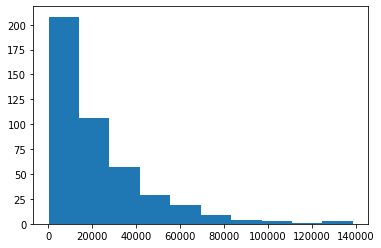

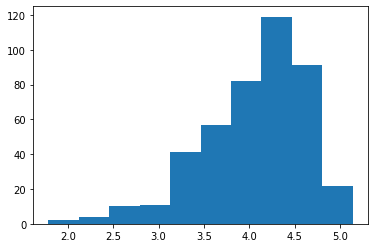

In [185]:
msum = np.sum(motifs, axis=0)
plt.hist(msum)
plt.figure()
plt.hist(np.log10(msum))

logging.info(f'Most motifs found for {mcols[msum == np.max(msum)]}')

In [205]:
# mTF = np.char.upper([x.split('(')[0] for x in mcols])
mTF = [x.split('(')[0] for x in mcols]
conv = [x for x in mTF if x in TFs_human]
disc = [x for x in mTF if x not in TFs_human]

logging.info(f'Retaining {len(conv)} out of {len(mTF)}')

15:54:22 INFO     Retaining 124 out of 439


In [ ]:
## Parse cellranger pfm motifs to homer motifs

In [159]:
import tempfile
import shutil
import os

def Generate_homer_motifs(TF_names: str, ref_pfm: str):
    """
    Generate a .motifs refence from a

    Args:
        ds                    Loom connection

    Remarks:

    """

    out_dir = os.path.join(chromograph.__path__[0], 'references', 'human_TFs.motifs')
    logging.info("Generating homer motifs, saving in chromograph reference directory")

    pfm_dir = tempfile.mkdtemp()

    ## Load data from .pfm reference and split into seperate files
    with open(ref_pfm) as f:
        i = 0
        valid = 0
        for line in f:

            if i%5 == 0:
                TF = line.split('_')[0][1:]
                ## If TF is in list of valids
                if TF in TF_names:
                    valid = 1
                    f_pmf = os.path.join(pfm_dir, f'{TF}.pfm')
                    f = open(f_pmf, "w")
                    f.write(line)
                else:
                    valid = 0
            else:
                if valid:
                    f.write(line)

                    if i%5 == 4:
                        f.close    
            i += 1
    logging.info('Saved pfms to temporary folder')
    logging.info('Calculating expected threshold')
    
    ## Calculate the maximum score (perfect match) and average score with 1 substitution
    mmax = []
    msub = []

    ## Load files and convert to numpy arrays
    for fpfm in [os.path.join(pfm_dir, x) for x in os.listdir(pfm_dir)]:
        with open(fpfm) as f:
            i = 0
            motif = []
            for line in f:
                if i%5 == 0:
                    TF = line.split('_')[0][1:]
                else:
                    line = [x for x in line.split(' ') if x is not ""]
                    motif.append(line[2:-2])

                    if i%5 == 4:
                        f.close    
                i += 1
        motif = np.array(motif).astype(int).T
        motif = np.around(div0(motif, np.sum(motif, axis = 1).reshape(motif.shape[0],1)), decimals=3) ## Convert to PPM

        ## Get maximum score for PPM
        mscore = 0
        for x in range(motif.shape[0]):
            mscore += np.log((np.max(motif[x,:])+0.001) / .25)
        mmax.append(np.around(mscore, decimals = 3))

        ## Get scores for single substitutions to 2nd highest scoring value
        sub_scores = []
        for i in range(motif.shape[0]):
            score = 0
            for x in range(motif.shape[0]):
                if x != i:
                    score += np.log((np.max(motif[x,:])+0.001) / .25)
                if x == i:
                    score += np.log((np.partition(motif[x,:], -2)[-2]+0.001) / .25)
            sub_scores.append(score)

        msub.append(np.around(np.mean(sub_scores), decimals=3))

    # calc the trendline between maximum and substitution scores
    z = np.polyfit(mmax, msub, 1)
    p = np.poly1d(z)

    logging.info('Saving motifs to chromograph reference')
    ## Reload all motifs and save in correct format
    with open(out_dir, 'w') as fmotif:
        for fpfm in [os.path.join(pfm_dir, x) for x in os.listdir(pfm_dir)]:
            with open(fpfm) as f:
                i = 0
                motif = []
                for line in f:
                    if i%5 == 0:
                        TF = line.split('_')[0][1:]
                    else:
                        line = [x for x in line.split(' ') if x is not ""]
                        motif.append(line[2:-2])

                        if i%5 == 4:
                            f.close    
                    i += 1
            motif = np.array(motif).astype(int).T
            motif = np.around(div0(motif, np.sum(motif, axis = 1).reshape(motif.shape[0],1)), decimals=3)

            ## Get maximum score
            score = 0
            for x in range(motif.shape[0]):
                score += np.log((np.max(motif[x,:])+0.001) / .25)
                
            ## Calculate expected threshold
#             thres = p(score) + 1
            thres = score * 0.97
    
            ## Write header as >NAME NAME threshold
            header = [f'>{TF}', TF, str(thres)]
            fmotif.write('\t'.join(header) + '\n')

            ## Write PPM to file
            for line in motif.tolist():
                line = [str(x) for x in line]
                fmotif.write('\t'.join(line) + '\n')

        ## Close file
        fmotif.close()

    logging.info('Deleting tempdir')
    
    ## Finish by removing tempdir
    shutil.rmtree(pfm_dir)
    
    return 

from cytograph.species.human import TFs_human
ref_pfm = "/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/regions/motifs.pfm"
Generate_homer_motifs(TFs_human, ref_pfm)

10:32:22 INFO     Generating homer motifs, saving in chromograph reference directory
10:32:23 INFO     Saved pfms to temporary folder
10:32:23 INFO     Calculating expected threshold
10:32:24 INFO     Saving motifs to chromograph reference
10:32:24 INFO     Deleting tempdir


In [174]:
motif_ref = "/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/regions/motifs.pfm"
pfm_dir = os.path.join(config.paths.build, 'pfms')

if not os.path.exists(pfm_dir):
    os.mkdir(pfm_dir)

## Split up motifs
with open(motif_ref) as f:
    i = 0
    valid = 0
    for line in f:
        
        if i%5 == 0:
            TF = line.split('_')[0][1:]
            if TF in TFs_human:
                valid = 1
                f_pmf = os.path.join(pfm_dir, f'{TF}.pfm')
                f = open(f_pmf, "w")
                f.write(line)
            else:
                valid = 0
        else:
            if valid:
                ## Write here
                f.write(line)
                
                if i%5 == 4:
                    f.close    
        i += 1        

#### Load motif as np array

From Position Frequence (PFM) to ACGT (rows) to Position Probability (PPM) with ACGT (columns)

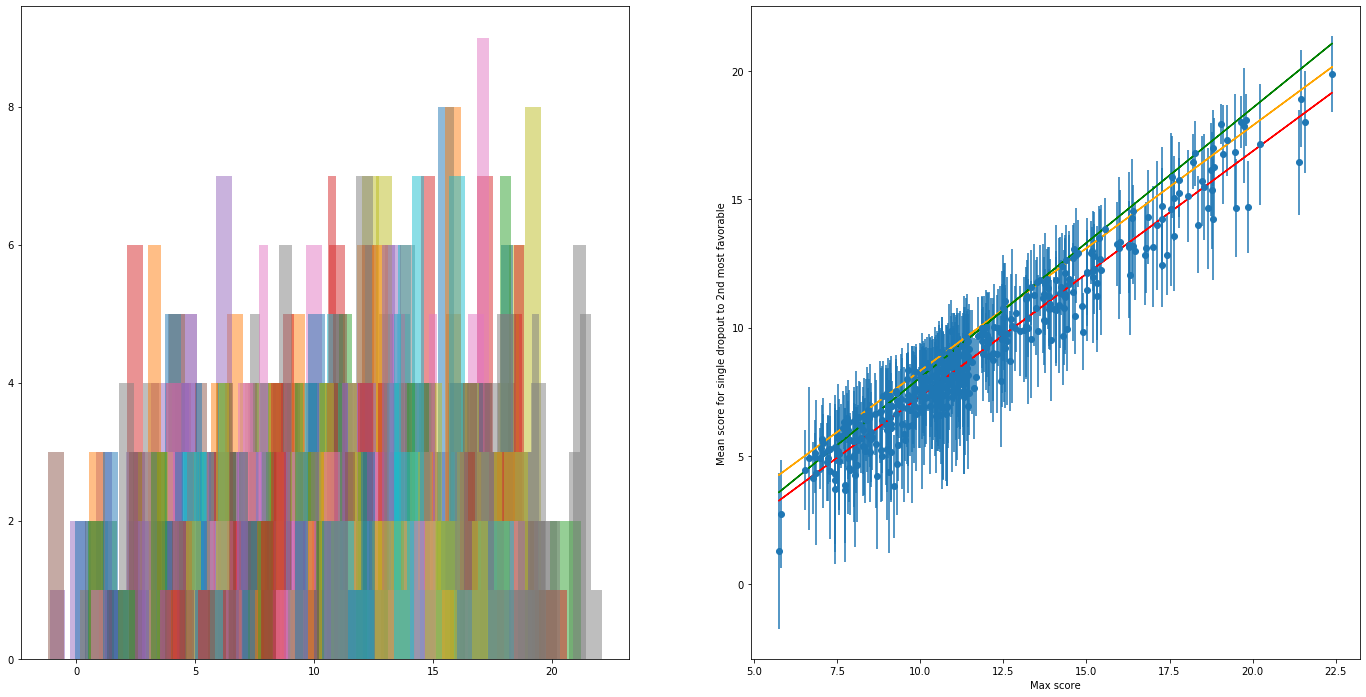

In [280]:
path_pfm = os.path.join(config.paths.build, 'pfms')

mmax = []
msub = []
mstd = []

fig, ax = plt.subplots(1,2, figsize=(24,12))

for fpfm in [os.path.join(path_pfm, x) for x in os.listdir(path_pfm)]:
    with open(fpfm) as f:
        i = 0
        motif = []
        for line in f:
            if i%5 == 0:
                TF = line.split('_')[0][1:]
            else:
                line = [x for x in line.split(' ') if x is not ""]
                motif.append(line[2:-2])

                if i%5 == 4:
                    f.close    
            i += 1
    motif = np.array(motif).astype(int).T
    motif = np.around(div0(motif, np.sum(motif, axis = 1).reshape(motif.shape[0],1)), decimals=3)

    ## Get scores
    mscore = 0
    for x in range(motif.shape[0]):
        mscore += np.log((np.max(motif[x,:])+0.001) / .25)
    mmax.append(np.around(mscore, decimals = 3))
    
    sub_scores = []
    for i in range(motif.shape[0]):
        score = 0
        for x in range(motif.shape[0]):
            if x != i:
                score += np.log((np.max(motif[x,:])+0.001) / .25)
            if x == i:
                score += np.log((np.partition(motif[x,:], -2)[-2]+0.001) / .25)
        sub_scores.append(score)
        
    msub.append(np.around(np.mean(sub_scores), decimals=2))
    mstd.append(np.around(np.std(sub_scores), decimals=2))
    ax[0].hist(sub_scores, alpha=.5)
    
# calc the trendline
z = np.polyfit(mmax, msub, 1)
p = np.poly1d(z)
# ax[1].scatter(mmax, msub)
ax[1].errorbar(mmax, msub, yerr=mstd, fmt='o')
ax[1].set_xlabel('Max score')
ax[1].set_ylabel('Mean score for single dropout to 2nd most favorable')
ax[1].plot(mmax, p(mmax), c = 'red')
ax[1].plot(mmax, p(mmax) + 1, c = 'orange')
ax[1].plot(mmax, p(mmax) * 1.1, c = 'green')

### Generate motif file

In [177]:
path_pfm = os.path.join(config.paths.build, 'pfms')
motif_file = os.path.join('tmp', 'custom.motifs')

with open(motif_file, 'w') as fmotif:
    for fpfm in [os.path.join(path_pfm, x) for x in os.listdir(path_pfm)]:
        with open(fpfm) as f:
            i = 0
            motif = []
            for line in f:
                if i%5 == 0:
                    TF = line.split('_')[0][1:]
                else:
                    line = [x for x in line.split(' ') if x is not ""]
                    motif.append(line[2:-2])

                    if i%5 == 4:
                        f.close    
                i += 1
        motif = np.array(motif).astype(int).T
        motif = np.around(div0(motif, np.sum(motif, axis = 1).reshape(motif.shape[0],1)), decimals=3)

        ## Get maximum score
        score = 0
        for x in range(motif.shape[0]):
            score += np.log((np.max(motif[x,:])+0.001) / .25)
        thres = p(score)

        header = [f'>{TF}', TF, str(thres)]
        fmotif.write('\t'.join(header) + '\n')

        for line in motif.tolist():
            line = [str(x) for x in line]
            fmotif.write('\t'.join(line) + '\n')

    fmotif.close()

## Generating MOTIF.loom

Annotating peaks usign HOMER

/home/camiel/homer/bin/annotatePeaks.pl /data/proj/scATAC/chromograph/build_20200220_Midbrain/peaks/Compounded_peaks.bed hg38 -gtf /data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf -m /home/camiel/chromograph/chromograph/references/human_TFs.motifs > /home/camiel/chromograph/notebooks/tmp/annotated_peaks.txt

In [161]:
def read_HOMER(file):
    '''
    Read the output of HOMER into a numpy array
    '''
    table = []
    TFs = []
    with open(file) as f:
        i = 0
        for line in f:
            if i == 0:
                cols = ['ID'] + line.split('\t')[1:]
                cols = [x.rstrip() for x in cols]
                cols = np.array([x.replace('/', '-',) for x in cols])
                clim = np.where(cols == 'GC%')[0][0] + 1
                TF_cols = [x.split(' ')[0] for x in cols[clim:]]
            if i> 0:
                table.append([x.rstrip() for x in line.split('\t')][:clim])
                tline = [x.rstrip() for x in line.split('\t')][clim:]
                tline = [x is not '' for x in tline]
                TFs.append(tline)
            i += 1

    return cols[:clim], np.array(table), TF_cols, np.array(TFs)

f_annot = os.path.join('/home/camiel/misc/chromograph_tmp', 'annotated_peaks.txt')
cols, table, TF_cols, TFs = read_HOMER(f_annot)

In [110]:
config

Config(execution=Config(memory=256, n_cpus=52, n_gpus=0), params=Config(HPF_factors=48, Normalization='TF-IDF', batch_keys=[], bin_size=5000, clusterer='louvain', cov=1.75, factorization='PCA', k=25, k_pooling=10, level=5000, max_fraction_MT_genes=0.05, min_fraction_good_cells=0.4, n_factors=50, nn_space='auto', passedQC=False, peak_depth=25000000.0, peak_min_cells=50, skip_metadata=False, skip_missing_samples=False), paths=Config(HOMER='/home/camiel/homer/bin', MACS='/home/camiel/anaconda3/envs/chromograph/bin/macs2', autoannotation='', bedtools='/data/bin/bedtools2/bin/', build='/home/camiel/chromograph/notebooks', cell_ranger='data/proj/chromium', fastqs='', index='', metadata='/nfs/sanger-data/10X/DB/sqlite3_chromium.db', qc='', ref='/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/', samples='/data/proj/scATAC/samples'), steps=('nn', 'embeddings', 'clustering'))

Text(0.5, 1.0, 'Peaks per Motif')

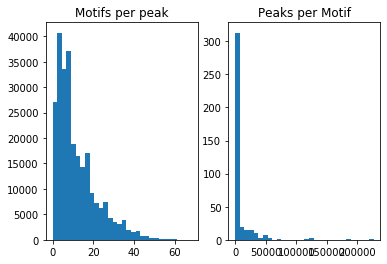

In [162]:
fig, ax = plt.subplots(1,2)
per_peak = np.sum(TFs, axis=1)
ax[0].hist(per_peak, bins = 30)
ax[0].set_title('Motifs per peak')
per_motif = np.sum(TFs, axis=0)
ax[1].hist(per_motif, bins=30)
ax[1].set_title('Peaks per Motif')

In [171]:
from cytograph.manifold import BalancedKNN
f = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    with loompy.new('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as dsout:
        dsout.add_columns(np.zeros([TFs.shape[1], ds.shape[1]]), col_attrs=ds.ca, row_attrs={'Gene': np.array(TF_cols), 
                                                                                             'Total_peaks': np.array(np.sum(TFs, axis = 0))})
        dsout.col_graphs = ds.col_graphs
        
        logging.info(f'New loom file has shape{dsout.shape}')
        for (ix, selection, view) in ds.scan(axis=1):
            for x in range(len(TF_cols)):
                dsout[x,selection] = np.sum(view[TFs[:,x], :], axis=0)
            logging.info(f'finished {max(selection)}')
            
        dsout.layers['MMP'] = div0(dsout[:,:], (1e-6 * ds.ca['NPeaks']))
        
        ## Smooth motif enrichments
        k = 25
        logging.info(f'Loading the network')
        bnn = BalancedKNN(k=k, metric='euclidean', maxl=2 * k, sight_k=2 * k, n_jobs=-1)
        bnn.bknn = dsout.col_graphs.KNN

        logging.info('Smoothing over the graph')
        dsout['smooth'] = 'float16'
        dsout['smooth'] = bnn.smooth_data(dsout['MMP'][:,:], only_increase=False)
        logging.info(f'Finished smoothing')    
        
        ## Calculating modified Z-score
        dsout.ra['Median'] = dsout['smooth'].map([np.median], axis=0)[0]
        dsout.ra['MADS'] = np.median(abs(dsout['smooth'][:,:] - dsout.ra['Median'].reshape([dsout.shape[0],1])), axis=1)
        dsout['MZ'] = 0.6745 * div0(dsout['smooth'][:,:] - dsout.ra['Median'].reshape([dsout.shape[0],1]), dsout.ra['MADS'].reshape([dsout.shape[0],1]))

14:41:18 INFO     New loom file has shape(391, 9452)
14:41:40 INFO     finished 511
14:41:57 INFO     finished 1023
14:42:11 INFO     finished 1535
14:42:26 INFO     finished 2047
14:42:41 INFO     finished 2559
14:42:57 INFO     finished 3071
14:43:13 INFO     finished 3583
14:43:29 INFO     finished 4095
14:43:44 INFO     finished 4607
14:43:58 INFO     finished 5119
14:44:14 INFO     finished 5631
14:44:29 INFO     finished 6143
14:44:45 INFO     finished 6655
14:45:00 INFO     finished 7167
14:45:15 INFO     finished 7679
14:45:30 INFO     finished 8191
14:45:45 INFO     finished 8703
14:46:02 INFO     finished 9215
14:46:11 INFO     finished 9451
14:46:12 INFO     Loading the network
14:46:12 INFO     Smoothing over the graph
14:46:14 INFO     Finished smoothing


In [113]:
f = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    print(ds.attrs['tissue'])

Midbrain


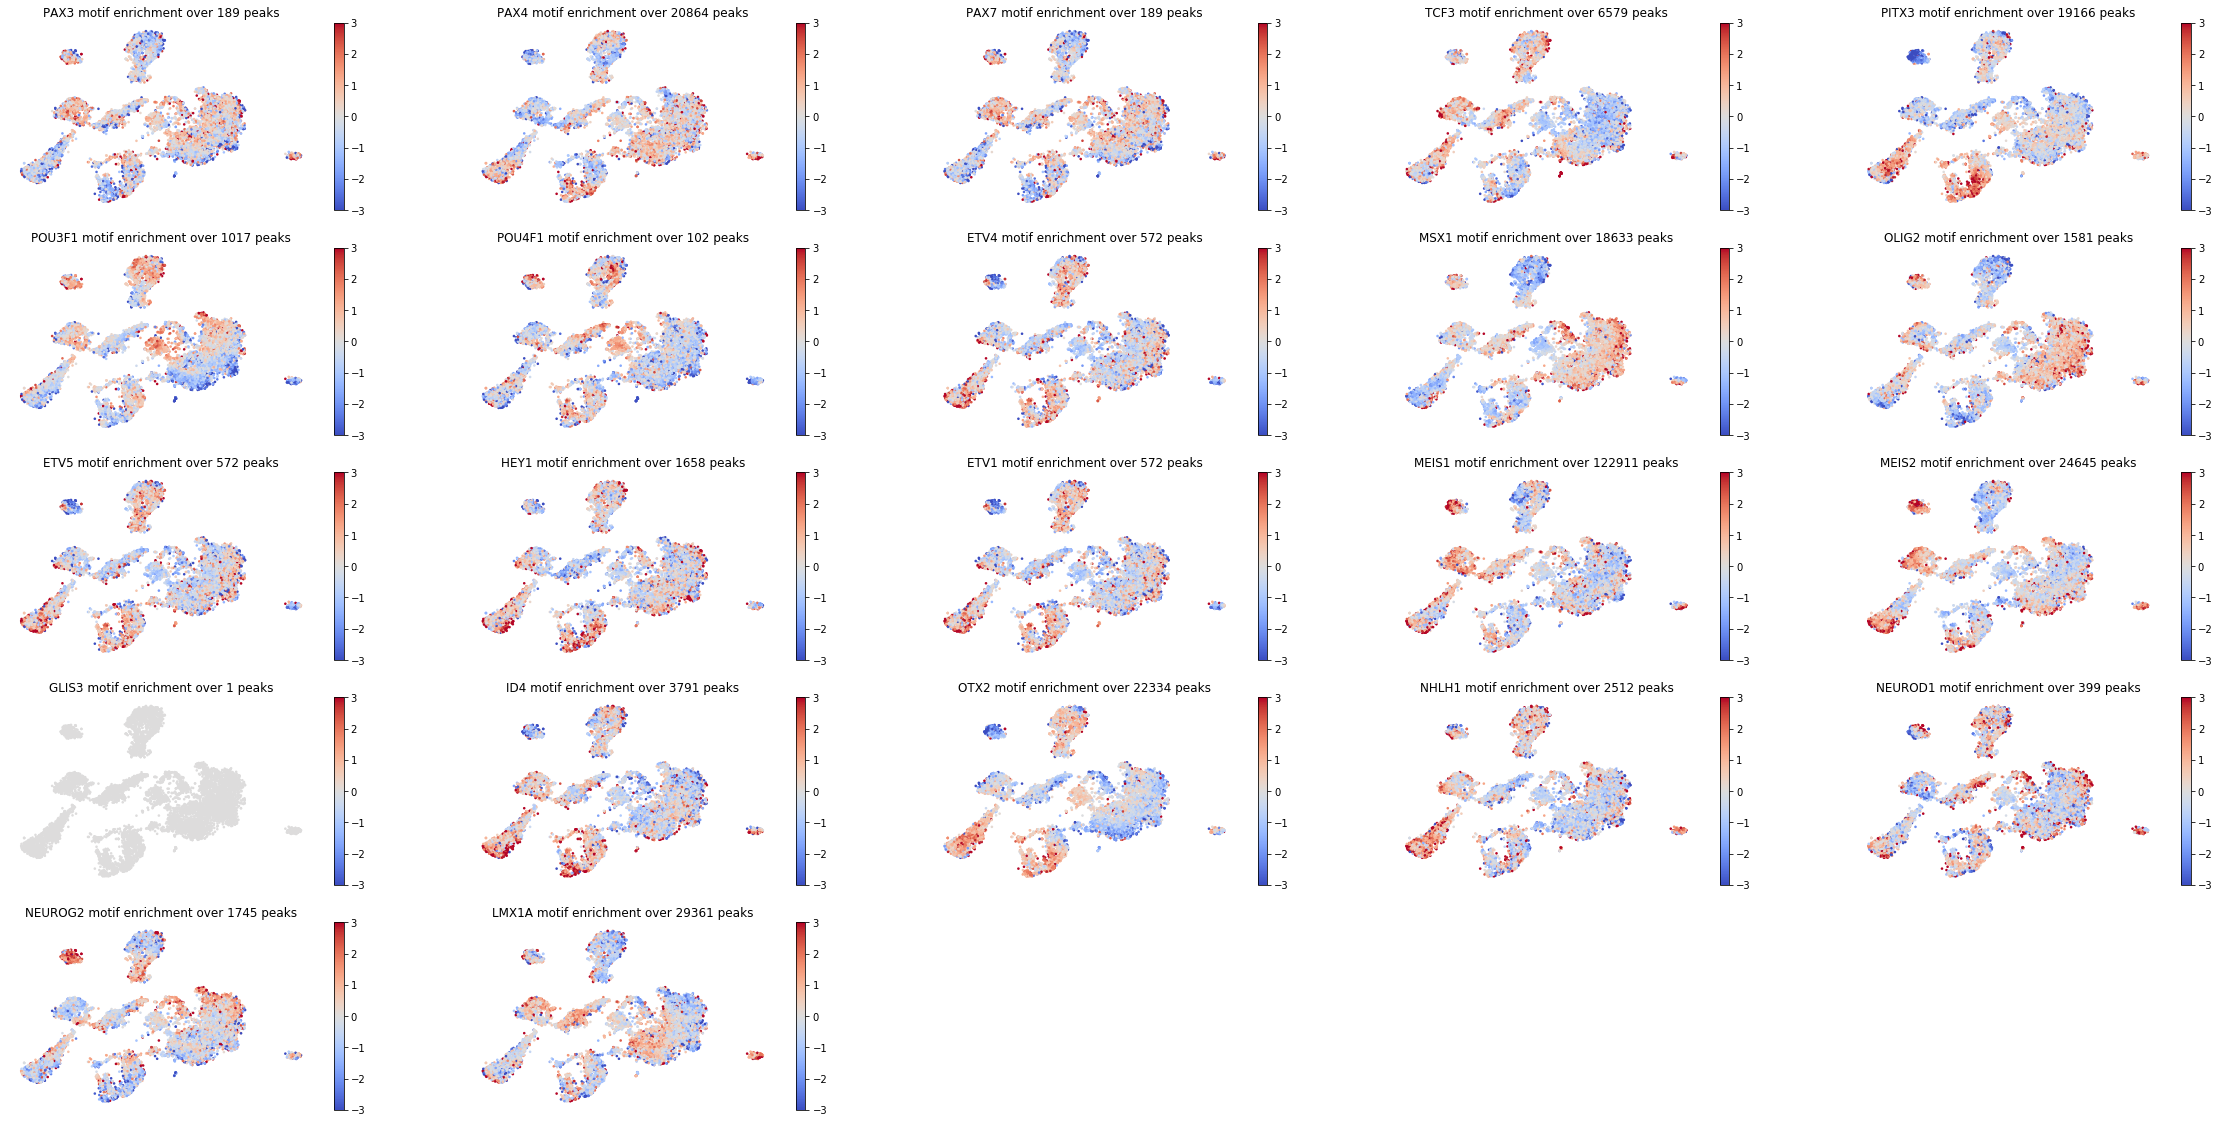

In [236]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    m = [marker for marker in markers if marker in ds.ra['Gene']]
    motif_plot(ds, '/home/camiel/misc/chromograph_tmp/motif_plots.png', m, 'TSNE')

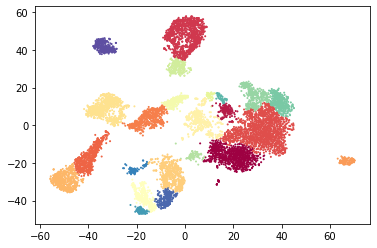

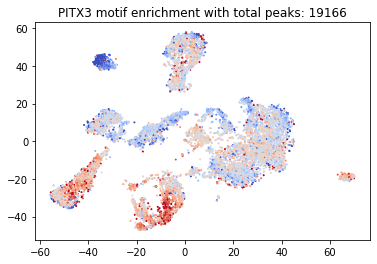

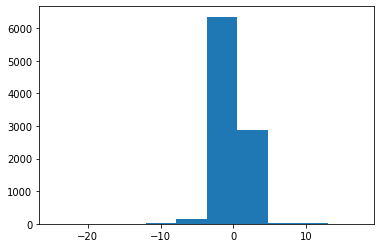

-24.564223838067846 17.216377946469702


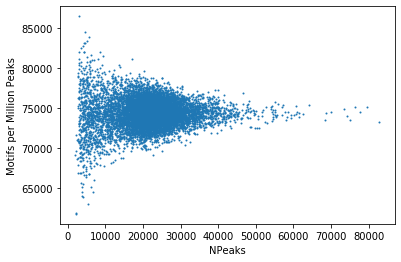

In [28]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    gene = 'PITX3'
    
    plt.scatter(ds.ca['TSNE'][:,0], ds.ca['TSNE'][:,1], s=1, c = ds.ca['Clusters'], cmap='Spectral')
    plt.show()
    
    plt.scatter(ds.ca['TSNE'][:,0], ds.ca['TSNE'][:,1], s=1, c = ds['MZ'][np.where(ds.ra['Gene']==gene)[0][0],:], 
                cmap='coolwarm', vmin=-3, vmax=3)
    plt.title(f'{gene} motif enrichment with total peaks: {ds.ra["Total_peaks"][ds.ra["Gene"]==gene][0]}')
    plt.show()
    x = ds['MZ'][np.where(ds.ra['Gene']==gene)[0][0]]
    plt.hist(x)
    plt.show()
    plt.scatter(ds.ca['NPeaks'], ds['MMP'][np.where(ds.ra['Gene']==gene)[0][0],:], s=1)
    plt.xlabel('NPeaks')
    plt.ylabel('Motifs per Million Peaks')
    print(min(x), max(x))

In [210]:
from diffxpy.api import test
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
#     stats = test.pairwise(
#         data=ds[''][:,:].T,
#         grouping=ds.ca['Clusters'],
#         lazy=False,
#         sample_description=ds.ca.CellID,
#         gene_names=ds.ra.Gene,
#         test='t-test',
#         size_factors = ds.ca['NPeaks'],
#         noise_model=None,
#         pval_correction='by_test',
#         is_sig_zerovar=False
#     )
    stats = test.versus_rest(
        data=ds[''][:,:].T,
        grouping=ds.ca['Clusters'],
        lazy=False,
        sample_description=ds.ca.CellID,
        gene_names=ds.ra.Gene,
        test='t-test',
        size_factors = ds.ca['NPeaks'],
        noise_model=None,
        pval_correction='global',
        is_sig_zerovar=False
    )
stats

INFO:diffxpy:additional kwargs: {'lazy': False}


19:26:32 INFO     additional kwargs: {'lazy': False}


In [273]:
from chromograph.pipeline.TF_IDF import TF_IDF
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    tf_idf = TF_IDF()
    tf_idf.fit(ds)
    X = tf_idf.transform(ds[''][:,:])
    
    stats = test.versus_rest(
        data=X.T,
        grouping=ds.ca['Clusters'],
        lazy=False,
        sample_description=ds.ca.CellID,
        gene_names=ds.ra.Gene,
        test='t-test',
        noise_model=None,
        pval_correction='global',
        is_sig_zerovar=False
    )

INFO:diffxpy:additional kwargs: {'lazy': False}


20:22:26 INFO     additional kwargs: {'lazy': False}


In [274]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    for x in range(len(stats.groups)):

        fc = 0
        npeaks = 1000
        valid = (stats.log2_fold_change()[0,x,:]>fc)&(ds.ra['Total_peaks']>npeaks)
        if sum(valid) > 9:
            sig = stats.qval[0,x,valid][stats.qval[0,x,valid].argsort()[9]]
            logging.info(f'Significance threshold: {sig} genes: {stats.gene_ids[(stats.qval[0,x,:] < sig)&(valid)]}')
        elif sum(valid) > 0:
            sig = np.max(stats.qval[0,x,valid])             
            logging.info(f'Less than 10. Significance threshold: {sig} genes: {stats.gene_ids[(stats.qval[0,x,:] < sig)&(valid)]}')

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
20:22:33 INFO     Significance threshold: 2.0215977729250423e-17 genes: ['OTX1' 'OTX2' 'GATA5' 'POU3F1' 'POU3F2' 'GATA2' 'GATA3']
20:22:33 INFO     Significance threshold: 6.789226528681168e-05 genes: ['JUNB' 'FOSL2' 'KLF5' 'OTX1' 'OTX2' 'KLF16' 'CDX1']
20:22:33 INFO     Significance threshold: 1.0211697203168123e-15 genes: ['RELA' 'MSX1' 'MSX2' 'BHLHE22' 'NFE2' 'BSX' 'HOXA10' 'NR4A1' 'TFE3']
20:22:33 INFO     Significance threshold: 5.1561334520315686e-14 genes: ['NR4A2' 'FOSL1' 'CDX2' 'KLF16' 'GATA5' 'TCF3' 'MYB' 'RBPJ' 'GATA3']
20:22:33 INFO     Significance threshold: 5.5988464259033096e-12 genes: ['HOXA5' 'NRF1' 'EMX1' 'JDP2' 'TEAD3' 'BHLHE40' 'BHLHE22' 'NFE2' 'TFE3']
20:22:33 INFO     Significance threshold: 6.7415232098497676e-06 genes: ['RORA' 'FOSL1' 'HEY2' 'PITX3' 'KLF16' 'GATA5' 'HEY1' 'GATA2' 'GATA3']
20:

In [217]:
for x in range(len(stats.groups)):
    stats.qval

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Signature:
stats.summary(
    qval_thres=None,
    fc_upper_thres=None,
    fc_lower_thres=None,
    mean_thres=None,
    **kwargs,
) -> pandas.core.frame.DataFrame
Docstring: Summarize differential expression results into an output table.
File:      ~/anaconda3/envs/chromograph/lib/python3.7/site-packages/diffxpy/testing/det.py
Type:      method


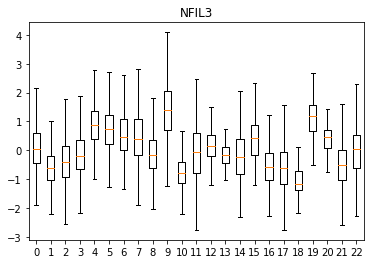

In [114]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    gene = 'NFIL3'
    v = ds['MZ'][np.where(ds.ra['Gene']==gene)[0][0],:]
    labels = np.unique(ds.ca['Clusters'])
    boxes = [v[np.where(ds.ca['Clusters'] == x)] for x in labels]
    
    plt.boxplot(boxes, labels=labels, showfliers=False)
    plt.title(gene)

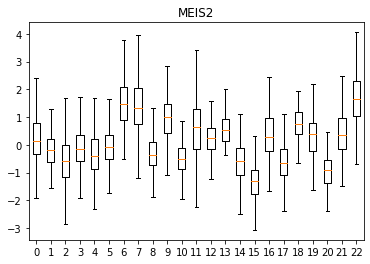

In [107]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    gene = 'MEIS2'
    v = ds['MZ'][np.where(ds.ra['Gene']==gene)[0][0],:]
    labels = np.unique(ds.ca['Clusters'])
    boxes = [v[np.where(ds.ca['Clusters'] == x)] for x in labels]
    
    plt.boxplot(boxes, labels=labels, showfliers=False)
    plt.title(gene)

In [57]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    clus = 0
    n = ds.ra['Total_peaks'] > 1000
    q = stats.qval[0][clus,:] < 0.05
    fc = stats.log2_fold_change()[0][clus,:] > 0.05
    sum(fc&q&n)
    print(ds.ra['Gene'][fc&q&n])

['POU3F1']


/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(array([8973.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          20.]),
 array([  -3.10844709,  104.9377691 ,  212.98398528,  321.03020147,
         429.07641766,  537.12263385,  645.16885004,  753.21506623,
         861.26128242,  969.30749861, 1077.35371479]),
 <a list of 10 Patch objects>)

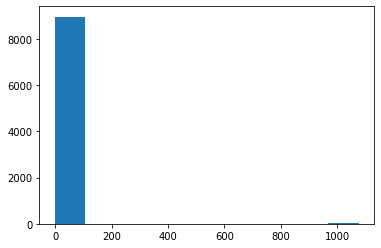

In [65]:
plt.hist(stats.log2_fold_change()[0].flatten())

200

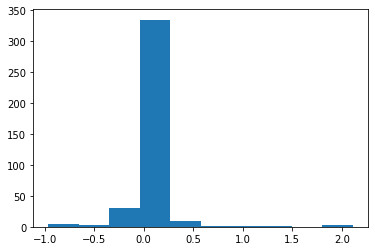

In [334]:
plt.hist(stats.log2_fold_change()[0][0,:])
sum(stats.log2_fold_change()[0][0,:]<0)

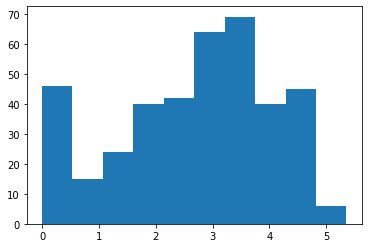

In [317]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    plt.hist(np.log10(ds.ra['Total_peaks']+1))

In [262]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_motif.loom') as ds:
    ds.aggregate('/home/camiel/misc/chromograph_tmp/agg.loom', group_by='Clusters')

In [261]:
?ds.aggregate

Signature:
ds.aggregate(
    out_file: str = None,
    select: numpy.ndarray = None,
    group_by: Union[str, numpy.ndarray] = 'Clusters',
    aggr_by: str = 'mean',
    aggr_ca_by: Dict[str, str] = None,
) -> numpy.ndarray
Docstring:
Aggregate the Loom file by applying aggregation functions to the main matrix as well as to the column attributes

Args:
        out_file        The name of the output Loom file (will be appended to if it exists)
        select          Bool array giving the columns to include (or None, to include all)
        group_by        The column attribute to group by, or an np.ndarray of integer group labels
        aggr_by         The aggregation function for the main matrix
        aggr_ca_by      A dictionary of aggregation functions for the column attributes (or None to skip)

Returns:
        m                       Aggregated main matrix

Remarks:
        aggr_by gives the aggregation function for the main matrix
        aggr_ca_by is a dictionary with column

In [265]:
with loompy.connect('/home/camiel/misc/chromograph_tmp/agg.loom') as ds:
    print(ds.ca.keys())
    print(ds.ra.keys())
    print(ds.shape)
    print(ds[:,:])

[]
['Gene', 'MADS', 'Median', 'Total_peaks']
(391, 23)
[[1.21507177e+02 1.53214286e+02 1.22511561e+02 ... 1.46953704e+02
  9.67600000e+01 1.05113497e+02]
 [1.88397129e+00 2.21428571e+00 2.29479769e+00 ... 2.62037037e+00
  1.99200000e+00 1.63190184e+00]
 [2.08614833e+03 2.65577273e+03 2.13042293e+03 ... 2.50754630e+03
  1.66778800e+03 1.78891718e+03]
 ...
 [1.91387560e-02 4.54545455e-02 5.29865125e-02 ... 1.75925926e-01
  1.20000000e-02 3.68098160e-02]
 [1.91387560e-02 4.54545455e-02 5.29865125e-02 ... 1.75925926e-01
  1.20000000e-02 3.68098160e-02]
 [2.96519139e+01 3.81818182e+01 2.97244701e+01 ... 3.51574074e+01
  2.36720000e+01 2.63895706e+01]]


In [253]:
for x in range(Pcorr.shape[1]):
    print(f'{Genes[Pcorr[:,x] == min(Pcorr[:,x])]} with adjusted p value {min(Pcorr[:,x])}')

['HOXA10'] with adjusted p value 5.734391855818491e-22
['RORB'] with adjusted p value 3.504477443868094e-10
['KLF16'] with adjusted p value 1.8242185309167432e-41
['FOXA1'] with adjusted p value 9.90190824888749e-34
['KLF16'] with adjusted p value 1.6331575517708975e-33
['NR4A1'] with adjusted p value 2.2304249440755497e-13
['SNAI2'] with adjusted p value 4.829792562952172e-17
['KLF16'] with adjusted p value 4.5431926828961e-31
['PITX3'] with adjusted p value 3.4516723102532726e-10
['BARHL2'] with adjusted p value 2.0531638141699637e-32
['GATA2'] with adjusted p value 1.4938934222935326e-43
['FOSL1'] with adjusted p value 1.6441867873575535e-08
['MLX' 'MLXIPL' 'TFEC'] with adjusted p value 1.6695762723627884e-12
['USF1'] with adjusted p value 0.00022533973448335512
['EN2'] with adjusted p value 5.326992986012651e-07
['EN2'] with adjusted p value 0.0003809247352414662
['CREB3'] with adjusted p value 6.21837234749752e-17
['ESRRB'] with adjusted p value 4.292052158948305e-15
['RORB'] with

In [ ]:
f = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    peak_IDs = ds.ra['ID']
    TFs = reorder_by_IDs(np.vstack([table[:,0], TFs.T]).T, peak_IDs)
    TFs = TFs[:,1:] == 'True'
    Peak_count = []
    for x, TF_ID in enumerate(TF_cols):
        Peak_count.append(sum(TFs[:,x]))
        print(f'{Peak_count[x]} {ds[TFs[:,x],:].shape}')

(1664, 9452)
(49, 9452)
